# Paper 1 artwork - Figure 5 (VGSC haplotype structure)

genome-wide phasing only

## Setup

In [82]:
%run setup.ipynb
%matplotlib inline

In [83]:
from scipy.cluster.hierarchy import _convert_to_double
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy

In [84]:
# define the gene region
region = 'PARA'
region_vgsc = '2L', 2358158, 2431617

In [85]:
callset_phased = phase1_ar31.callset_phased
callset_phased

<HDF5 file "ag1000g.phase1.ar3.1.haplotypes.h5" (mode r)>

In [86]:
prot_code_dict = {
    'Ala' : 'A',
    'Arg' : 'R',
    'Asn' : 'N',
    'Asp' : 'D',
    'Asx' : 'B',
    'Cys' : 'C',
    'Glu' : 'E',
    'Gln' : 'Q',
    'Glx' : 'Z',
    'Gly' : 'G',
    'His' : 'H',
    'Ile' : 'I',
    'Leu' : 'L',
    'Lys' : 'K',
    'Met' : 'M',
    'Phe' : 'F',
    'Pro' : 'P',
    'Ser' : 'S',
    'Thr' : 'T',
    'Trp' : 'W',
    'Tyr' : 'Y',
    'Val' : 'V'
    }

In [87]:
def load_data(callset_phased, chrom, start=None, stop=None, n_variants=None):

    # load variant positions 
    pos = allel.SortedIndex(callset_phased[chrom]['variants']['POS'][:])
    
    # locate the region of interest
    if start and stop:
        loc = pos.locate_range(start, stop)
    elif start and n_variants:
        start_idx = bisect.bisect_left(pos, start)
        stop_idx = start_idx + n_variants
        loc = slice(start_idx, stop_idx)
    elif stop and n_variants:
        stop_idx = bisect.bisect_right(pos, stop)
        start_idx = stop_idx - n_variants
        loc = slice(start_idx, stop_idx)
    else:
        raise ValueError('bad args')
    
    # obtain haplotypes for the region of interest
    pos = pos[loc]
    g = allel.GenotypeArray(callset_phased[chrom]['calldata']['genotype'][loc])
    h = g.to_haplotypes()
    
    # remove colony individuals
    # we can use this cheat instead of .take because we know that the last 16 haps are colony
    h = h[:, :-16]
    
    # grab the whole original (unfiltered) data set
    callset = phase1_ar31.callset

    # setup variant table using the original data whole chromo arm
    vtbl = allel.VariantChunkedTable(callset[chrom]['variants'],
                                     names=['POS', 'REF', 'ALT', 'num_alleles', 'AC', 'AF', 'FILTER_PASS', 'ANN'],
                                     index='POS')

    # need to find intersect of positions from phased section and the original data - produce a boolean array
    # length=original data and compress the chunked table accordingly

    vtbl_pos = allel.SortedIndex(vtbl['POS'])
    loc_isec = vtbl_pos.locate_intersection(pos)[0]

    # this produceds the variants corresponding to the haplotypes
    vtbl_isec = vtbl.compress(loc_isec)[:]
    vtbl_isec.set_index('POS')

    # some diagnostics
    x = vtbl_isec.ANN['Annotation_Impact'][:]
    print(collections.Counter(x))
    x = vtbl_isec.ANN['Annotation'][:]
    print(collections.Counter(x))

    # find missense variants at some appreciable frequency
    vtbl_missense = vtbl_isec.query(
        '(AC[:, 0] > 7) & '
        '(ANN["Annotation"] != b"synonymous_variant") & '
        '(ANN["Annotation"] != b"splice_region_variant&intron_varia") & '
        '(ANN["Annotation"] != b"splice_region_variant&synonymous_v") & '
        '(ANN["Annotation"] != b"intron_variant") & '
        '(ANN["Annotation"] != b"dwnstream_gene_variant") & '
        '(ANN["Annotation"] != b"upstream_gene_variant")'
        ,
        vm='python')

    # extract positions for the missense variants
    pos_missense = vtbl_missense.POS[:]

    # locate the missense variants within the gene
    loc_missense = vtbl_isec.index.locate_keys(pos_missense)

    # extract haplotypes for the missense variants
    h_missense = h.compress(loc_missense, axis=0)

    # labels for the missense mustations
#     missense_mutations_ = ['%s (%s)' % (str(t, 'ascii')[2:], str(s, 'ascii')[2:]) 
#                            for s, t in zip(vtbl_missense['ANN'][:]['HGVS_c'], vtbl_missense['ANN'][:]['HGVS_p'])]
    missense_mutations_ = ['%s' % str(t, 'ascii')[2:] 
                           for t in vtbl_missense['ANN'][:]['HGVS_p']]

    missense_mutations = []
    for v in missense_mutations_:
        for a in prot_code_dict.keys():
            v = v.replace(a, prot_code_dict[a])
        missense_mutations.append(v)
    
    return pos, h, h_missense, missense_mutations

In [88]:
pos, h, h_missense, missense_mutations = \
    load_data(callset_phased, *region_vgsc)

Counter({b'MODIFIER': 1607, b'LOW': 58, b'MODERATE': 45})
Counter({b'intron_variant': 1607, b'synonymous_variant': 48, b'missense_variant': 44, b'splice_region_variant&intron_varia': 8, b'splice_region_variant&synonymous_v': 2, b'missense_variant&splice_region_var': 1})


In [89]:
# upstream 
pos_ups, h_ups, _, _ = load_data(callset_phased, '2L', stop=pos[0], n_variants=pos.shape[0])
h_ups

Counter({b'MODIFIER': 1557, b'LOW': 105, b'MODERATE': 47, b'HIGH': 1})
Counter({b'intergenic_region': 1071, b'upstream_gene_variant': 249, b'downstream_gene_variant': 161, b'synonymous_variant': 95, b'intron_variant': 51, b'missense_variant': 47, b'5_prime_UTR_variant': 16, b'3_prime_UTR_variant': 9, b'splice_region_variant&intron_varia': 6, b'splice_region_variant&synonymous_v': 3, b'start_lost': 1, b'5_prime_UTR_premature_start_codon_': 1})


<HaplotypeArray shape=(1710, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [90]:
pos_ups

0,1,2,3,4,...,1705,1706,1707,1708,1709
2140926,2140945,2140962,2140970,2140985,...,2358056,2358063,2358084,2358093,2358254


In [91]:
# downstream 
pos_dns, h_dns, _, _ = load_data(callset_phased, '2L', start=pos[-1], n_variants=pos.shape[0])
h_dns

Counter({b'MODIFIER': 1539, b'LOW': 102, b'MODERATE': 68, b'HIGH': 1})
Counter({b'intergenic_region': 1092, b'downstream_gene_variant': 259, b'upstream_gene_variant': 155, b'synonymous_variant': 97, b'missense_variant': 67, b'intron_variant': 15, b'5_prime_UTR_variant': 14, b'3_prime_UTR_variant': 4, b'5_prime_UTR_premature_start_codon_': 3, b'splice_region_variant&intron_varia': 2, b'stop_gained': 1, b'missense_variant&splice_region_var': 1})


<HaplotypeArray shape=(1710, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
1 1 0 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 0 0 1 1 ... 1 0 1 0 1

In [92]:
pos_dns

0,1,2,3,4,...,1705,1706,1707,1708,1709
2431542,2431662,2431725,2431729,2431783,...,2547843,2547869,2547871,2547875,2547876


## Plot missense haplotypes

In [93]:
def plot_missense_haplotypes(ax, h, mut_labels):
    h = h.copy()
    # colours for colormap
    mycol = ['r', 'w', 'k'] 
    # alter rows with kdr mutations for color map to pick up
#     known_muts = ['L995S (2984T>C)', 'L995F (2985A>T)', 'N1570Y (4708A>T)']
    known_muts = ['L995S', 'L995F', 'N1570Y']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=1, zorder=-10)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    lbl = [l for l in mut_labels[::-1]]
#     lbl = ['%s' % l for l in mut_labels[::-1]]
    ax.set_yticklabels(lbl, family='monospace', fontsize=6)
    ax.set_ylabel('Non-synonymous SNPs')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
#     ax.set_xticks([])
    ax.yaxis.tick_left()
    ax.set_xticks([])
    # rasterize to avoid SVG antialiasing issues and reduce file size
    ax.set_rasterization_zorder(-5)
#     ax.set_xticks(list(range(0, h.shape[1], 200)) + [h.shape[1]])
#     ax.xaxis.tick_bottom()
#     ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)

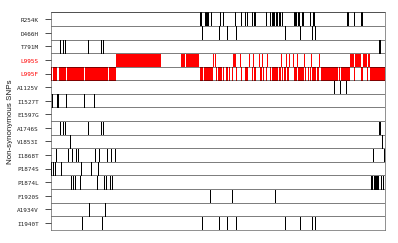

In [94]:
fig, ax = plt.subplots()
plot_missense_haplotypes(ax, h_missense, missense_mutations)

## Cluster haplotypes

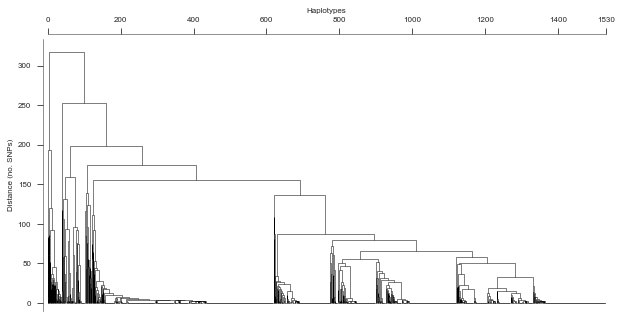

In [95]:
def plot_dendrogram(h, ax, method='complete', color_threshold=0, above_threshold_color='k'):
    
    # compute distance matrix
    dist = allel.stats.pairwise_distance(h, 'hamming') * h.shape[0]

    # HACKING SCIPY TO GET TO OLD CLUSTERING METHOD
    # https://github.com/scipy/scipy/blob/v0.18.1/scipy/cluster/hierarchy.py#L470-L667
    # 1. fiddle with format
    y = _convert_to_double(np.asarray(dist, order='c'))
    # 2. get n
    n = int(distance.num_obs_y(dist))
    # 3. do clustering
    method = dict(single=0, complete=1)[method]
    z = _hierarchy.linkage(y, n, method)    

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(z, no_labels=True, count_sort=True, 
                                           color_threshold=color_threshold, 
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-10)
#     ax.set_xlim(left=-10)
    ax.set_ylabel('Distance (no. SNPs)')
    ax.autoscale(axis='x', tight=True)
    return z, r

fig, ax = plt.subplots(figsize=(10, 5))
plot_dendrogram(h, ax);

## Assemble figure

In [96]:
populations = phase1_ar3.pop_ids
pop_colours = phase1_ar3.pop_colors
pop_labels = phase1_ar3.pop_labels

In [97]:
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [98]:
def fig_hap_structure(h, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(5, 4), 
                      fn=None, dpi=150, height_ratios=(2.5, .2, 2.8, .2), hap_pops=None, legend=True):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 4
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r = plot_dendrogram(h, ax_dend, color_threshold=0)
    ax_dend.set_ylim(bottom=-5)
#     for xmin, xmax in vspans:
#         ax.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), 1,
#                                    facecolor='k', edgecolor='k', alpha=.1,
#                                    transform=ax.transAxes, zorder=20))
#     ax.vlines(vspans.flat, 0, 1, transform=ax.transAxes, linestyle=':')
#     if legend:
#         handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
#         ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = df_haplotypes.population.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_colours[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')

    # missense mutations
    if h_display is not None:
        ax_mut = fig.add_subplot(gs[2, 0])
        plot_missense_haplotypes(ax_mut, h_display.take(r['leaves'], axis=1), mutations)
        ax_mut.set_xticks([])
        ax_mut.yaxis.set_tick_params(length=3, pad=2)

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -20 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
            ax_pops.vlines([xmin, xmax], 0, 1, linestyle=':')
            ax_mut.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), h_display.shape[0],
                             facecolor='k', edgecolor='k', alpha=.1,
                             zorder=20))
            ax_mut.vlines([xmin, xmax], 0, h_display.shape[0], linestyle=':')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')
    
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
        
    return z, r

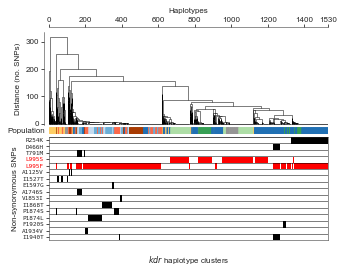

In [99]:
z, r = fig_hap_structure(h, h_missense, missense_mutations)

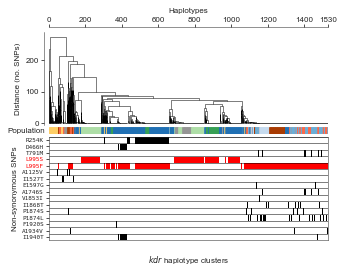

In [100]:
z_ups, r_ups = fig_hap_structure(h_ups, h_missense, missense_mutations)


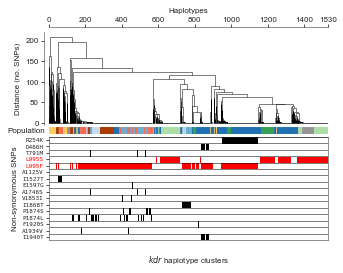

In [101]:
z_dns, r_dns = fig_hap_structure(h_dns, h_missense, missense_mutations)

# Cut the dendrogram

In [102]:
# gives the haplotype indices of the haplotypes in the n largest clusters
def find_clusters(z, n, threshold=12):
    
    # find clusters
    f = scipy.cluster.hierarchy.fcluster(z, threshold, criterion='distance')
    
    # compute cluster sizes
    fsz = np.bincount(f)
    
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    
    # take largest n
    fsort = fsort[:n]
    
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    
    return clusters

In [103]:
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)
    

In [104]:
fig.get_size_inches()

array([ 10.,   5.])

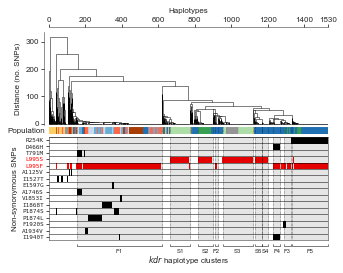

In [105]:
clustard = find_clusters(z, n=13, threshold=10)
vspans = [truspan(cluster, r) for cluster in clustard]
cluster_labels = ['F1', 'F5', 'S3', 'S1', 'S2', 'F3', 'F4', 'S4', 'S5', '', '', '', 'F2']
fig_hap_structure(h, h_missense, mutations=missense_mutations, vspans=np.array(vspans), cluster_labels=cluster_labels);
fig = plt.gcf()
ax_dend = fig.axes[0]
# ax_dend.text(-0.08, 1.2, 'a', transform=ax_dend.transAxes, ha='left', va='top', fontsize=10, fontweight='bold')
fig.savefig('../artwork/vgsc_haplotypes.pdf', jpeg_quality=100, dpi=600, bbox_inches='tight')


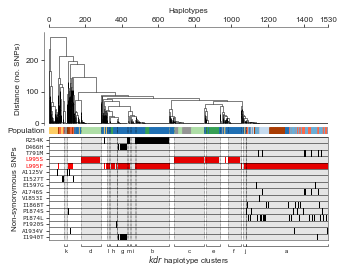

In [106]:
clustard_ups = find_clusters(z_ups, n=13, threshold=10)
vspans = [truspan(cluster, r_ups) for cluster in clustard_ups]
cluster_labels_ups = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
fig_hap_structure(h_ups, h_missense, mutations=missense_mutations, vspans=np.array(vspans), cluster_labels=cluster_labels_ups);

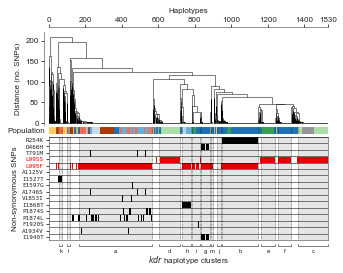

In [107]:
clustard_dns = find_clusters(z_dns, n=13, threshold=10)
vspans = [truspan(cluster, r_dns) for cluster in clustard_dns]
cluster_labels_dns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
fig_hap_structure(h_dns, h_missense, mutations=missense_mutations, vspans=np.array(vspans), cluster_labels=cluster_labels_dns);

### Compare clustering up and downstream

In [108]:
def compare_clusters(clustard1, clustard2, labels1, labels2):
    for c1, l1 in zip(clustard1, labels1):
        if l1:
            n_isec_max = 0
            l2_best = None
            l2_best_size = None
            for c2, l2 in zip(clustard2, labels2):
                n_isec = len(c1.intersection(c2))
                if n_isec > n_isec_max:
                    n_isec_max = n_isec
                    l2_best = l2
                    l2_best_size = len(c2)
            print(l1, len(c1), 'best match', l2_best, l2_best_size, 'intersection', n_isec_max, '{:.1f}%'.format(n_isec_max * 100 / len(c1)))


In [109]:
compare_clusters(clustard, clustard_ups, cluster_labels, cluster_labels_ups)

F1 464 best match a 448 intersection 445 95.9%
F5 196 best match b 181 intersection 179 91.3%
S3 165 best match c 164 intersection 164 99.4%
S1 108 best match d 108 intersection 108 100.0%
S2 79 best match e 74 intersection 74 93.7%
F3 42 best match h 42 intersection 42 100.0%
F4 38 best match g 56 intersection 37 97.4%
S4 37 best match f 71 intersection 35 94.6%
S5 36 best match f 71 intersection 35 97.2%
F2 14 best match l 13 intersection 13 92.9%


In [110]:
compare_clusters(clustard, clustard_dns, cluster_labels, cluster_labels_dns)

F1 464 best match a 405 intersection 401 86.4%
F5 196 best match b 197 intersection 194 99.0%
S3 165 best match c 164 intersection 164 99.4%
S1 108 best match d 118 intersection 105 97.2%
S2 79 best match e 79 intersection 79 100.0%
F3 42 best match i 42 intersection 42 100.0%
F4 38 best match g 51 intersection 38 100.0%
S4 37 best match f 70 intersection 34 91.9%
S5 36 best match f 70 intersection 35 97.2%
F2 14 best match m 13 intersection 13 92.9%


### Compare clustering special versus genome-wide phasing

In [111]:
hap_sample_labels = df_haplotypes.ox_code

In [112]:
cluster_samples = dict()
for l, c in zip(cluster_labels, clustard):
    cluster_samples[l] = set(hap_sample_labels.take(list(c)))

In [113]:
def save_cluster_membership(fn, h, clusters, cluster_labels):

    # save cluster membership
    cluster_membership = np.empty(h.shape[1], dtype='S2')
    cluster_membership[:] = b''
    for cluster, lbl in zip(clusters, cluster_labels):
        hidx = sorted(cluster)
        cluster_membership[hidx] = lbl.encode('ascii')[:2]

    np.save(fn, cluster_membership)

In [114]:
save_cluster_membership('../data/vgsc_cluster_membership.npy', h, clustard, cluster_labels)